GPU available: True
GPU: Tesla T4
Dataset sizes:
  Train: 27935
  Test: 6984


Map:   0%|          | 0/6984 [00:00<?, ? examples/s]


Sanity check:
  Columns: ['input_ids', 'attention_mask', 'labels']
  Label range: 0 - 6
  Sample labels: [6, 6, 3, 6, 3, 0, 3, 3, 0, 6]


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.838500,0.826199,0.698167,0.592234,0.636404,0.563158
2,0.717700,0.830898,0.693872,0.586981,0.636590,0.562685
3,0.610500,0.852927,0.703608,0.600406,0.642460,0.573705
4,0.505100,0.907719,0.692010,0.599303,0.614573,0.593040
5,0.435700,0.946183,0.691151,0.594887,0.615405,0.582027



🏁 Training finished!



📊 Final Results:
  eval_loss: 0.8529
  eval_accuracy: 0.7036
  eval_f1: 0.6004
  eval_precision: 0.6425
  eval_recall: 0.5737
  eval_runtime: 6.1233
  eval_samples_per_second: 1140.5560
  eval_steps_per_second: 17.9640
  epoch: 5.0000


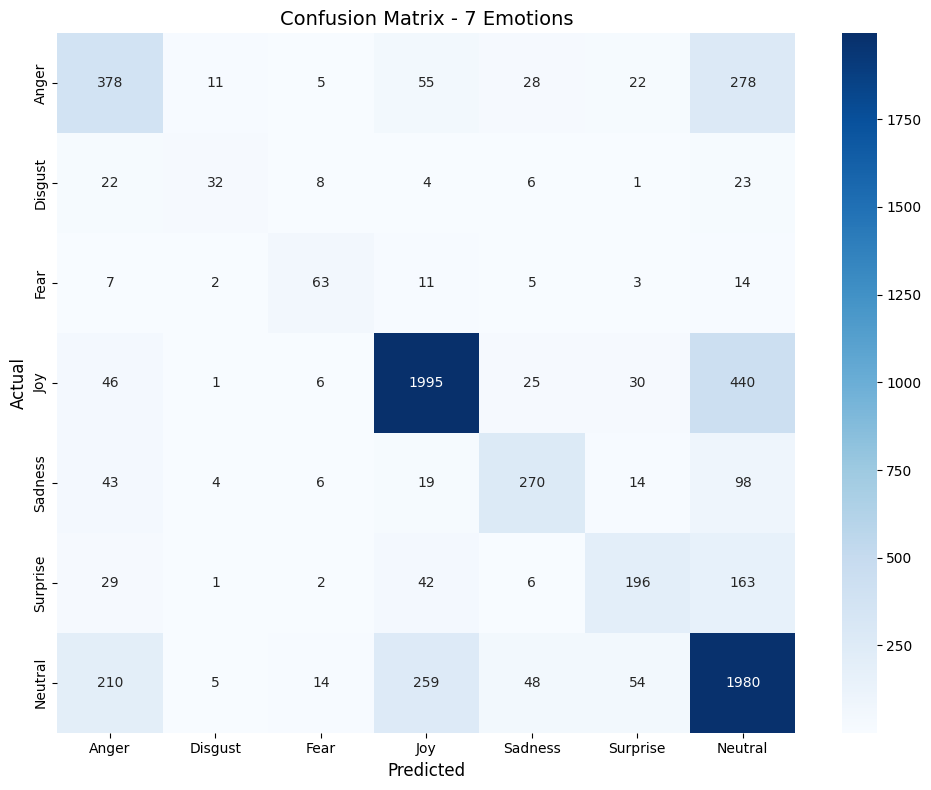

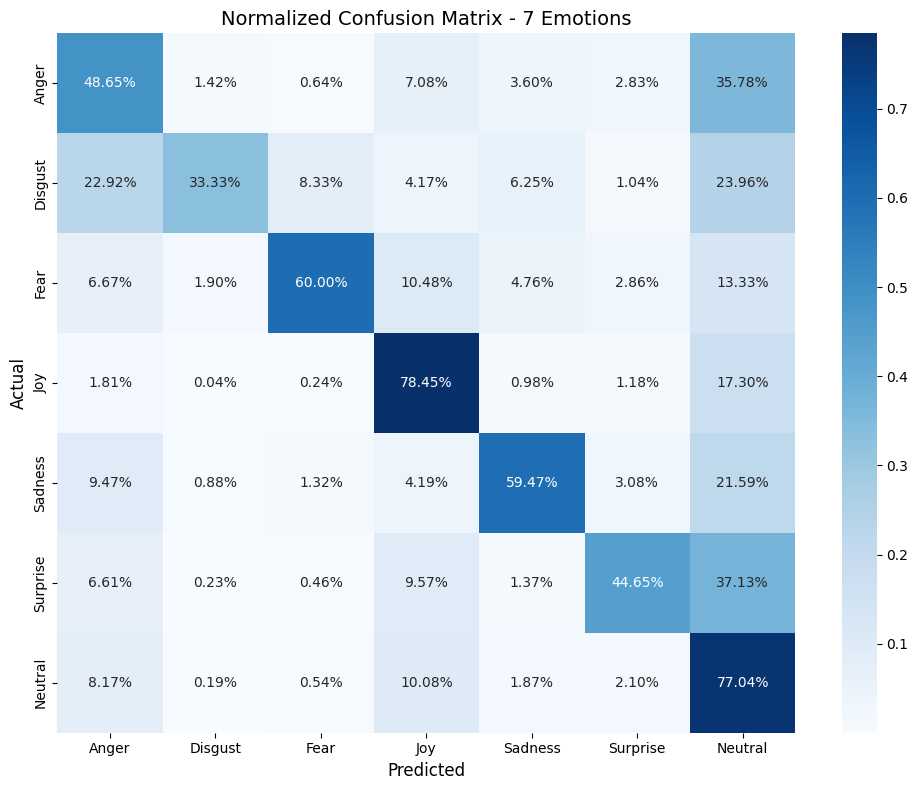


📋 Classification Report:
              precision    recall  f1-score   support

       Anger     0.5143    0.4865    0.5000       777
     Disgust     0.5714    0.3333    0.4211        96
        Fear     0.6058    0.6000    0.6029       105
         Joy     0.8365    0.7845    0.8097      2543
     Sadness     0.6959    0.5947    0.6413       454
    Surprise     0.6125    0.4465    0.5165       439
     Neutral     0.6609    0.7704    0.7115      2570

    accuracy                         0.7036      6984
   macro avg     0.6425    0.5737    0.6004      6984
weighted avg     0.7057    0.7036    0.7013      6984


📊 Per-class Accuracy:
  Anger: 48.65% (777 samples)
  Disgust: 33.33% (96 samples)
  Fear: 60.00% (105 samples)
  Joy: 78.45% (2543 samples)
  Sadness: 59.47% (454 samples)
  Surprise: 44.65% (439 samples)
  Neutral: 77.04% (2570 samples)


In [4]:
# =========================
# 0. Setup
# =========================
!pip install -q datasets transformers accelerate scikit-learn

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["WANDB_DISABLED"] = "true"

import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# =========================
# 1. Model & Tokenizer
# =========================
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# =========================
# 2. Load GoEmotions (Google)
# =========================
dataset = load_dataset("go_emotions")
label_names = dataset["train"].features["labels"].feature.names

# =========================
# 3. Map GoEmotions -> 7 emotions
# =========================
label_map = {
    "anger": 0, "annoyance": 0, "disapproval": 0,
    "disgust": 1,
    "fear": 2, "nervousness": 2,
    "joy": 3, "amusement": 3, "approval": 3, "gratitude": 3,
    "love": 3, "optimism": 3, "pride": 3, "relief": 3,
    "admiration": 3, "desire": 3, "caring": 3, "excitement": 3,
    "sadness": 4, "disappointment": 4, "grief": 4,
    "remorse": 4, "embarrassment": 4,
    "surprise": 5, "realization": 5, "confusion": 5,
    "neutral": 6
}

def map_goemotions(example):
    if len(example["labels"]) != 1:
        return {"text": example["text"], "new_label": -1}

    emotion = label_names[example["labels"][0]]
    if emotion not in label_map:
        return {"text": example["text"], "new_label": -1}

    return {"text": example["text"], "new_label": label_map[emotion]}

# Process dataset
processed = dataset["train"].map(map_goemotions)
processed = processed.filter(lambda x: x["new_label"] != -1)

# Split
split_dataset = processed.train_test_split(test_size=0.2, seed=42)

print("Dataset sizes:")
print(f"  Train: {len(split_dataset['train'])}")
print(f"  Test: {len(split_dataset['test'])}")

# =========================
# 4. Tokenization & Cleanup
# =========================
def tokenize_and_format(examples):
    tokenized = tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    tokenized["labels"] = examples["new_label"]
    return tokenized

# Apply tokenization and select only needed columns
train_dataset = split_dataset["train"].map(tokenize_and_format, batched=True)
train_dataset = train_dataset.select_columns(["input_ids", "attention_mask", "labels"])

eval_dataset = split_dataset["test"].map(tokenize_and_format, batched=True)
eval_dataset = eval_dataset.select_columns(["input_ids", "attention_mask", "labels"])

# Set format for PyTorch
train_dataset.set_format("torch")
eval_dataset.set_format("torch")

# Sanity check
print("\nSanity check:")
print(f"  Columns: {train_dataset.column_names}")
print(f"  Label range: {min(train_dataset['labels'])} - {max(train_dataset['labels'])}")
print(f"  Sample labels: {train_dataset['labels'][:10].tolist()}")

# =========================
# 5. Model
# =========================
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=7
)

# =========================
# 6. Metrics
# =========================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

# =========================
# 7. Training
# =========================
training_args = TrainingArguments(
    output_dir="./results_goemotions",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    learning_rate=2e-5,
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    fp16=True,
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)

# =========================
# 8. Train
# =========================
trainer.train()

print("\n🏁 Training finished!")

results = trainer.evaluate()
print("\n📊 Final Results:")
for key, value in results.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")

# =========================
# 9. Confusion Matrix
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions
predictions = trainer.predict(eval_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Define emotion names for the 7 classes
emotion_names = ["Anger", "Disgust", "Fear", "Joy", "Sadness", "Surprise", "Neutral"]

# Create confusion matrix
cm = confusion_matrix(true_labels, preds)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=emotion_names,
    yticklabels=emotion_names
)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - 7 Emotions', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

# Normalized version (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2%',
    cmap='Blues',
    xticklabels=emotion_names,
    yticklabels=emotion_names
)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Normalized Confusion Matrix - 7 Emotions', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=150)
plt.show()

# Classification report
print("\n📋 Classification Report:")
print(classification_report(true_labels, preds, target_names=emotion_names, digits=4))

# Per-class accuracy
print("\n📊 Per-class Accuracy:")
for i, emotion in enumerate(emotion_names):
    class_mask = true_labels == i
    class_acc = (preds[class_mask] == true_labels[class_mask]).mean()
    print(f"  {emotion}: {class_acc:.2%} ({class_mask.sum()} samples)")